<a href="https://colab.research.google.com/github/ChrisW2420/FedPKDG/blob/main/FedPKDG_for_Experiments.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# FedPKDG -- Prune + KD + GAN + FL
This prototype implements the algorithm in a distributed setting
TODO:
1. implement a FedAvg aggregator/server
2. build a centralised FL system with n clients connected to the server
3. design experiments to assess accuracy, efficiency, generalisation on homogenoeous data
4. repeat experiments on heterogeneous data, identical model sparsity
5. repeat experiments on heterogeneous data, different model sparsity, mimicing different computational capability of clients

# Setup and Imports

In [ ]:
# NB: package versions are very important
!pip install -q tensorflow-model-optimization # for pruning
!pip install -q git+https://github.com/tensorflow/docs # newest tf
!pip install --upgrade keras #newest keras

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 242.5/242.5 kB 6.4 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 20.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 311.2/311.2 kB 30.5 MB/s eta 0:00:00
  Attempting uninstall: keras
    Found existing installation: keras 2.15.0
    Uninstalling keras-2.15.0:
      Successfully uninstalled keras-2.15.0
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
tensorflow 2.15.0 requires keras<2.16,>=2.15.0, but you have keras 3.3.3 which is incompatible.


In [ ]:
# 3 versions of keras are used for different functionalities, imported as different names
import tensorflow as tf
import numpy as np
import tensorflow_model_optimization as tfmot
from tensorflow_model_optimization.sparsity import keras as sparsity
import tf_keras as keras_model #only for pruning
from tf_keras import layers as model_layers
import keras
import tempfile
from tf_keras.callbacks import EarlyStopping, Callback
from keras import ops, layers
from tensorflow_docs.vis import embed # for GAN
import matplotlib.pyplot as plt
from tf_keras.preprocessing.image import ImageDataGenerator
from sklearn.model_selection import train_test_split

# for KID score
from keras.applications.inception_v3 import InceptionV3, preprocess_input
from keras.datasets import mnist
from keras.preprocessing.image import img_to_array, array_to_img
from scipy.spatial.distance import cdist
from sklearn.metrics.pairwise import polynomial_kernel
from keras.models import load_model
from PIL import Image

## Loading Data

In [ ]:
# MNIST
# Prepare the train and test dataset.
batch_size = 32
(x_train, y_train), (x_test, y_test) = keras.datasets.mnist.load_data()

# Normalize data
x_train = x_train.astype("float32") / 255.0
x_train = np.reshape(x_train, (-1, 28, 28, 1))

x_test = x_test.astype("float32") / 255.0
x_test = np.reshape(x_test, (-1, 28, 28, 1))

11490434/11490434 ━━━━━━━━━━━━━━━━━━━━ 2s 0us/step


# Components Implementation

## Model zoo

### CNN

In [ ]:
def miniCNN():
  model = keras_model.Sequential(
      [
          keras_model.Input(shape=(28, 28, 1)),
          model_layers.Conv2D(8, (3, 3), strides=(2, 2), padding="same"),
          model_layers.Flatten(),
          model_layers.Dense(10),
      ],
      name="minicnn",
  )
  return model

def smallCNN():
  model = keras_model.Sequential(
      [
          keras_model.Input(shape=(28, 28, 1)),
          model_layers.Conv2D(8, (3, 3), strides=(2, 2), padding="same"),
          model_layers.LeakyReLU(alpha=0.2),
          model_layers.MaxPooling2D(pool_size=(2, 2), strides=(1, 1), padding="same"),
          model_layers.Conv2D(8, (3, 3), strides=(2, 2), padding="same"),
          model_layers.Flatten(),
          model_layers.Dense(10),
      ],
      name="smallcnn",
  )
  return model

def mediumCNN():
  model = keras_model.Sequential(
      [
          keras_model.Input(shape=(28, 28, 1)),
          model_layers.Conv2D(8, (3, 3), strides=(2, 2), padding="same"),
          model_layers.LeakyReLU(alpha=0.2),
          model_layers.MaxPooling2D(pool_size=(2, 2), strides=(1, 1), padding="same"),
          model_layers.Conv2D(16, (3, 3), strides=(2, 2), padding="same"),
          model_layers.LeakyReLU(alpha=0.2),
          model_layers.MaxPooling2D(pool_size=(2, 2), strides=(1, 1), padding="same"),
          model_layers.Conv2D(16, (3, 3), strides=(2, 2), padding="same"),
          model_layers.Flatten(),
          model_layers.Dense(10),
      ],
      name="mediumcnn",
  )
  return model

def bigCNN():
  model = keras_model.Sequential(
      [
          keras_model.Input(shape=(28, 28, 1)),
          model_layers.Conv2D(32, (3, 3), strides=(2, 2), padding="same"),
          model_layers.LeakyReLU(alpha=0.2),
          model_layers.MaxPooling2D(pool_size=(2, 2), strides=(1, 1), padding="same"),
          model_layers.Conv2D(32, (3, 3), strides=(2, 2), padding="same"),
          model_layers.LeakyReLU(alpha=0.2),
          model_layers.MaxPooling2D(pool_size=(2, 2), strides=(1, 1), padding="same"),
          model_layers.Conv2D(32, (3, 3), strides=(2, 2), padding="same"),
          model_layers.Flatten(),
          model_layers.Dense(10),
      ],
      name="bigcnn",
  )
  return model

### GAN

In [ ]:
num_channels = 1
num_classes = 10
image_size = 28
latent_dim = 64 # hyperparam, can tune

generator_in_channels = latent_dim + num_classes
discriminator_in_channels = num_channels + num_classes

# Create the discriminator.
def Discriminator():
  discriminator = keras.Sequential(
      [
          keras.layers.InputLayer((28, 28, discriminator_in_channels)),
          layers.Conv2D(64, (3, 3), strides=(2, 2), padding="same"),
          layers.LeakyReLU(negative_slope=0.2),
          layers.Conv2D(128, (3, 3), strides=(2, 2), padding="same"),
          layers.LeakyReLU(negative_slope=0.2),
          layers.GlobalMaxPooling2D(),
          layers.Dense(1),
      ],
      name="discriminator",
  )
  return discriminator

# Create the generator.
def Generator():
  generator = keras.Sequential(
      [
          keras.layers.InputLayer((generator_in_channels,)),
          # We want to generate 128 + num_classes coefficients to reshape into a
          # 7x7x(128 + num_classes) map.
          layers.Dense(7 * 7 * generator_in_channels),
          layers.LeakyReLU(negative_slope=0.2),
          layers.Reshape((7, 7, generator_in_channels)),
          layers.Conv2DTranspose(128, (4, 4), strides=(2, 2), padding="same"),
          layers.LeakyReLU(negative_slope=0.2),
          layers.Conv2DTranspose(128, (4, 4), strides=(2, 2), padding="same"),
          layers.LeakyReLU(negative_slope=0.2),
          layers.Conv2D(1, (7, 7), padding="same", activation="sigmoid"),
      ],
      name="generator",
  )
  return generator

## GAN

In [ ]:
class ConditionalGAN(keras.Model):
    def __init__(self, discriminator, generator, latent_dim):
        super().__init__()
        self.discriminator = discriminator
        self.generator = generator
        self.latent_dim = latent_dim
        self.seed_generator = keras.random.SeedGenerator(1337)
        self.gen_loss_tracker = keras.metrics.Mean(name="generator_loss")
        self.disc_loss_tracker = keras.metrics.Mean(name="discriminator_loss")

    @property
    def metrics(self):
        return [self.gen_loss_tracker, self.disc_loss_tracker]

    def compile(self, d_optimizer, g_optimizer, loss_fn):
        super().compile()
        self.d_optimizer = d_optimizer
        self.g_optimizer = g_optimizer
        self.loss_fn = loss_fn

    def train_step(self, data):
        # Unpack the data.
        real_images, one_hot_labels = data

        # Add dummy dimensions to the labels so that they can be concatenated with
        # the images. This is for the discriminator.
        image_one_hot_labels = one_hot_labels[:, :, None, None]
        image_one_hot_labels = ops.repeat(
            image_one_hot_labels, repeats=[image_size * image_size]
        )
        image_one_hot_labels = ops.reshape(
            image_one_hot_labels, (-1, image_size, image_size, num_classes)
        )

        # Sample random points in the latent space and concatenate the labels.
        # This is for the generator.
        batch_size = ops.shape(real_images)[0]
        random_latent_vectors = keras.random.normal(
            shape=(batch_size, self.latent_dim), seed=self.seed_generator
        )
        random_vector_labels = ops.concatenate(
            [random_latent_vectors, one_hot_labels], axis=1
        )

        # Decode the noise (guided by labels) to fake images.
        generated_images = self.generator(random_vector_labels)

        # Combine them with real images. Note that we are concatenating the labels
        # with these images here.
        fake_image_and_labels = ops.concatenate(
            [generated_images, image_one_hot_labels], -1
        )
        real_image_and_labels = ops.concatenate([real_images, image_one_hot_labels], -1)
        combined_images = ops.concatenate(
            [fake_image_and_labels, real_image_and_labels], axis=0
        )

        # Assemble labels discriminating real from fake images.
        labels = ops.concatenate(
            [ops.ones((batch_size, 1)), ops.zeros((batch_size, 1))], axis=0
        )

        # Train the discriminator.
        with tf.GradientTape() as tape:
            predictions = self.discriminator(combined_images)
            d_loss = self.loss_fn(labels, predictions)
        grads = tape.gradient(d_loss, self.discriminator.trainable_weights)
        self.d_optimizer.apply_gradients(
            zip(grads, self.discriminator.trainable_weights)
        )

        # Sample random points in the latent space.
        random_latent_vectors = keras.random.normal(
            shape=(batch_size, self.latent_dim), seed=self.seed_generator
        )
        random_vector_labels = ops.concatenate(
            [random_latent_vectors, one_hot_labels], axis=1
        )

        # Assemble labels that say "all real images".
        misleading_labels = ops.zeros((batch_size, 1))

        # Train the generator (note that we should *not* update the weights
        # of the discriminator)!
        with tf.GradientTape() as tape:
            fake_images = self.generator(random_vector_labels)
            fake_image_and_labels = ops.concatenate(
                [fake_images, image_one_hot_labels], -1
            )
            predictions = self.discriminator(fake_image_and_labels)
            g_loss = self.loss_fn(misleading_labels, predictions)
        grads = tape.gradient(g_loss, self.generator.trainable_weights)
        self.g_optimizer.apply_gradients(zip(grads, self.generator.trainable_weights))

        # Monitor loss.
        self.gen_loss_tracker.update_state(g_loss)
        self.disc_loss_tracker.update_state(d_loss)
        return {
            "g_loss": self.gen_loss_tracker.result(),
            "d_loss": self.disc_loss_tracker.result(),
        }

In [ ]:
# image generation functions
def generate_image(generator, target_class, latent_dim):
    noise_matrix = keras.random.normal(shape=(1, latent_dim))
    # Convert the target label to one-hot encoded vectors.
    target_label = keras.utils.to_categorical([target_class], num_classes)
    target_label = ops.cast(target_label, "float32")
    noise_and_labels = ops.concatenate([noise_matrix, target_label], 1)
    fake = generator.predict(noise_and_labels,verbose = 0)
    return fake

def pseudoDataset(generator, total_num, latent_dim, is_augment=True, batch_size=64): # producing equal numbers of samples for each class
    pseudo_images = []
    if is_augment:
      total_num = total_num//2
    for num in range(10):
      target_class = num
      # print('Generating', int(total_num/10), 'fake images of digit', num, '......')
      for _ in range(int(total_num/10)):
        generated_images = generate_image(generator, target_class, latent_dim)
        generated_images *= 255.0
        converted_images = generated_images.astype(np.uint8)
        converted_images = ops.image.resize(converted_images, (28, 28)).numpy().astype(np.uint8)
        pseudo_images.append(converted_images)
    pseudo_images = np.concatenate(pseudo_images, axis=0)
    x_pseudo = pseudo_images.astype("float32") / 255.0
    x_pseudo = np.reshape(x_pseudo, (-1, 28, 28, 1))
    pseudo_labels = np.repeat(np.arange(10), int(total_num/10))
    pseudo_labels = ops.cast(pseudo_labels, "uint8")

    if is_augment:
      x_pseudo, pseudo_labels = dataAugmentation(x_pseudo, pseudo_labels, total_num, batch_size) #1:1 augmentation to true ratio

    print('Added', pseudo_labels.shape, 'data points to the public dataset')
    return x_pseudo, pseudo_labels

In [ ]:
def dataAugmentation(x_initial, y_initial, num_augimg, batch_size):
  datagen = ImageDataGenerator(
      rotation_range=30,
      width_shift_range=0.1,
      height_shift_range=0.1,
      shear_range=0.1,
      zoom_range=0.2,
      horizontal_flip=True
  )

  # Create empty arrays to store the augmented data
  augmented_images = np.empty((num_augimg, 28, 28, 1), dtype=np.float32)
  augmented_labels = np.empty((num_augimg,), dtype=np.uint8)

  # Generate the augmented dataset
  counter = 0
  generated = 0

  for x_batch, y_batch in datagen.flow(x_initial, y_initial, batch_size=batch_size):
      current_batch_size = x_batch.shape[0]
      remaining_space = num_augimg - generated

      if remaining_space <= 0:
          break

      if current_batch_size > remaining_space:
          x_batch = x_batch[:remaining_space]
          y_batch = y_batch[:remaining_space]
          current_batch_size = remaining_space

      augmented_images[generated:generated + current_batch_size] = x_batch
      augmented_labels[generated:generated + current_batch_size] = y_batch

      generated += current_batch_size
      counter += 1

  # remove augmented images with invalid labels
  valid_indices = np.where(augmented_labels < 10)
  augmented_images = augmented_images[valid_indices]
  augmented_labels = augmented_labels[valid_indices]


  # Verify the shape of the augmented dataset
  print(f"Augmented dataset shape: {augmented_images.shape}, {augmented_labels.shape}")

  # Optionally, combine the augmented data with the original training data
  combined_images = np.concatenate((x_initial, augmented_images), axis=0)
  combined_labels = np.concatenate((y_initial, augmented_labels), axis=0)
  return combined_images, combined_labels

### KID score

In [ ]:
# Function to scale images to the size required by InceptionV3 (299x299) and convert grayscale to RGB
def scale_images(images, new_shape):
    images_list = []
    for img in images:
        img = np.repeat(img, 3, axis=-1)  # Convert grayscale to RGB by repeating channels
        new_image = array_to_img(img)
        new_image = new_image.resize(new_shape, Image.NEAREST)
        images_list.append(img_to_array(new_image))
    return np.array(images_list)

# Function to calculate the activations of the images using the InceptionV3 model
def calculate_activations(images):
    model = InceptionV3(include_top=False, pooling='avg', input_shape=(299, 299, 3))
    images = preprocess_input(images)
    activations = model.predict(images)
    return activations

# Function to calculate the KID score
def calculate_kid(act1, act2):
    act1, act2 = np.atleast_2d(act1), np.atleast_2d(act2)
    m = act1.shape[0]
    n = act2.shape[0]

    k_11 = polynomial_kernel(act1, act1, degree=3)
    k_22 = polynomial_kernel(act2, act2, degree=3)
    k_12 = polynomial_kernel(act1, act2, degree=3)

    kid = k_11.sum() / (m * m) + k_22.sum() / (n * n) - 2 * k_12.sum() / (m * n)
    return kid

def kid_score(generator):
# Load the MNIST dataset
  (_, _), (real_images, _) = mnist.load_data()
  real_images = np.expand_dims(real_images, axis=-1)

  # Assuming your GAN generator is defined and loaded
  # generator = ... (Your trained GAN generator model)
  # Example: generator = load_model('path_to_your_trained_generator.h5')

  # Generate images using the GAN generator
  num_images = 100  # Number of images to generate
  latent_dim = 64  # Example latent dimension, replace with your generator's input dimension

  #!!! swap out the generator to get kid score
  generated_images=pseudoDataset(generator, num_images, latent_dim, is_augment=False, batch_size=64)

  # Scale both sets of images
  generated_images = scale_images(generated_images[0], (299, 299))
  real_images = scale_images(real_images[:num_images], (299, 299))  # Use the same number of real images as generated

  # Calculate the activations
  act1 = calculate_activations(generated_images)
  act2 = calculate_activations(real_images)

  # Calculate the KID score
  kid = calculate_kid(act1, act2)
  print(f'KID score: {kid}')
  return kid

## Pruning

In [ ]:
def prune_finetrain(base_model, _epochs, x_toprune, y_toprune, target_sparsity, fine_tune_epochs, validation_split=0.1, batch_size=32):
  callbacks = [
      sparsity.UpdatePruningStep()
  ]
  steps_per_epoch = len(x_toprune)*(1-validation_split) // batch_size
  if fine_tune_epochs<_epochs:
    begin_step=int(steps_per_epoch*fine_tune_epochs)
  end_step=int(steps_per_epoch*_epochs)+1
  # print('begin_step=', begin_step, 'end_step=', end_step, 'target_sparsity=',target_sparsity)
  pruning_schedule = sparsity.PolynomialDecay(initial_sparsity=0, final_sparsity=target_sparsity,
                                              begin_step=begin_step, end_step=end_step) # TODO: tune begin_step, consider fining training before starting to prune

  model_for_pruning = sparsity.prune_low_magnitude(base_model, pruning_schedule=pruning_schedule) #default constant sparsity of 50%

  model_for_pruning.compile(
        optimizer='adam',
        loss=keras_model.losses.SparseCategoricalCrossentropy(from_logits=True),
        metrics=[keras_model.metrics.SparseCategoricalAccuracy()]
  )

  model_for_pruning.fit(
      x=x_toprune,
      y=y_toprune,
      batch_size=batch_size,
      validation_split=validation_split,
      callbacks=callbacks,
      epochs=_epochs,
      verbose = 0
  )
  pruned_model = sparsity.strip_pruning(model_for_pruning)

  return pruned_model


# Model size metrics

def get_model_sparsity(model):
    total_weights = 0
    zero_weights = 0
    for weight in model.get_weights():
        total_weights += weight.size
        zero_weights += np.count_nonzero(weight == 0)
    return zero_weights / total_weights

def get_gzipped_model_size(model):
  # Returns size of gzipped model, in bytes.
  import os
  import zipfile

  _, keras_file = tempfile.mkstemp('.h5')
  model.save(keras_file, include_optimizer=False)

  _, zipped_file = tempfile.mkstemp('.zip')
  with zipfile.ZipFile(zipped_file, 'w', compression=zipfile.ZIP_DEFLATED) as f:
    f.write(keras_file)

  return os.path.getsize(zipped_file)

## Knowledge Distillation

In [ ]:
class Distiller(keras_model.Model):
    def __init__(self, get_teacher_logits, student, alpha=0.3, temperature=4, **kwargs):
        super(Distiller, self).__init__(**kwargs)
        self.student = student
        self.get_teacher_logits = get_teacher_logits

    def compile(self, optimizer, metrics, student_loss_fn, distillation_loss_fn, alpha, temperature, **kwargs):
        super(Distiller, self).compile(optimizer=optimizer, metrics=metrics, **kwargs)
        self.student_loss_fn = student_loss_fn
        self.student.compile(optimizer=optimizer, metrics=metrics, loss=self.student_loss_fn)
        self.distillation_loss_fn = distillation_loss_fn
        self.alpha = alpha
        self.temperature = temperature

    def train_step(self, data):
        # Unpack the data
        x, y = data

        teacher_predictions = self.get_teacher_logits(x)

        with tf.GradientTape() as tape:
            # Forward pass of the student
            student_predictions = self.student(x, training=True)

            # Calculate the task-specific loss
            task_loss = self.student_loss_fn(y, student_predictions)

            # Calculate the soft targets and the distillation loss
            soft_targets = tf.nn.softmax(teacher_predictions / self.temperature)

            student_soft = tf.nn.softmax(student_predictions / self.temperature)
            distillation_loss = self.distillation_loss_fn(soft_targets, student_soft)

            # Calculate the total loss
            total_loss = (1 - self.alpha) * task_loss + self.alpha * distillation_loss * (self.temperature ** 2)

        # Compute gradients and update weights
        trainable_vars = self.student.trainable_variables
        gradients = tape.gradient(total_loss, trainable_vars)
        self.optimizer.apply_gradients(zip(gradients, trainable_vars))

        # Update metrics
        self.compiled_metrics.update_state(y, student_predictions)
        results = {m.name: m.result() for m in self.metrics}
        results.update({"task_loss": task_loss, "distillation_loss": distillation_loss, "total_loss": total_loss})
        return results

    def test_step(self, data):
        # Unpack the data
        x, y = data

        # Forward pass of the student
        y_pred = self.student(x, training=False)

        # Calculate the task-specific loss
        task_loss = self.student_loss_fn(y, y_pred)

        # Update the metrics
        self.compiled_metrics.update_state(y, y_pred)
        return {m.name: m.result() for m in self.metrics}

    def call_model(self):
      return self.student

# Helper Function Implementation

- confusion matrix
-

In [ ]:
def set_model_weights_to_zero(model):
    for layer in model.layers:
        zero_weights = [np.zeros_like(w) for w in layer.get_weights()]
        layer.set_weights(zero_weights)
    return model

In [ ]:
def if_synced(model1, model2):
    for layer1, layer2 in zip(model1.layers, model2.layers):
          weights1 = layer1.get_weights()
          weights2 = layer2.get_weights()
          for w1, w2 in zip(weights1, weights2):
              if not np.array_equal(w1, w2):
                  print('different weights, syncing failed')
    print('weights synced for client')

In [ ]:
# #FL early stopping
  #best_loss = 0
  #counter=[0]#round, patience=2
# loss, accuracy=Server.cnn.evaluate(x_test, y_test,verbose=0)
# print('Round',round,'global:',accuracy)
# if loss<best_loss:
#   best_loss=loss
#   counter[0]=round
# elif round-counter[0]>2:
#   break

## visualisation

In [ ]:
def plot_fl_train(client_acc, server_acc, client_loss, server_loss, name_1='Client Average', name_2='Server'):
  # Indices for y-values
  indices1 = list(range(1,len(client_acc)+1))
  indices2 = list(range(1,len(server_acc)+1))
  indices3 = list(range(1,len(client_loss)+1))
  indices4 = list(range(1,len(server_loss)+1))

  # Create subplots
  fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 6))

  title1 = name_1+name_2+'CNN Accuracy'
  title2 = name_1+name_2+'CNN Loss'

  # Plot first two arrays on the left
  ax1.plot(indices1, client_acc, label=name_1)
  ax1.plot(indices2, server_acc, label=name_2)
  ax1.set_xlabel('no. of rounds')
  ax1.set_ylabel('accuracy')
  ax1.set_title(title1)
  ax1.legend()

  # Plot second two arrays on the right
  ax2.plot(indices3, client_loss, label=name_1)
  ax2.plot(indices4, server_loss, label=name_2)
  ax2.set_xlabel('no. of rounds')
  ax2.set_ylabel('loss')
  ax2.set_title(title2)
  ax2.legend()

  # Display the plot
  plt.tight_layout()
  plt.show()

## data splitting

In [ ]:
def sample_training_data(sample_rate):
    # Ensure the sample_rate is within the valid range
    if not 0 < sample_rate <= 1:
        raise ValueError("Sample rate must be between 0 and 1.")

    # Split the data to get the sampled proportion
    x_sample, _, y_sample, _ = train_test_split(x_train, y_train, train_size=sample_rate, random_state=42)

    return x_sample, y_sample

In [ ]:
def print_dist(y_train, name):
  unique, counts = np.unique(y_train, return_counts=True)
  label_distribution = dict(zip(unique, counts))
  # Print the label distribution
  print("Label Distribution in Training Set ", name, ":")
  for label, count in label_distribution.items():
      print(f"Label {label}: {count} instances")

In [ ]:
# to obtain client heterogeneous distribution and visualise
def dirichlet_split(x_train, y_train, alpha=0.5, num_clients=10):
    # Create list to hold subsets for each client
    client_data = []

    for _ in range(num_clients):
        # Use Dirichlet distribution to generate proportions for each class

        proportions = np.random.dirichlet(alpha=np.repeat(alpha, 10))

        # Determine number of samples per class for the current client
        num_samples_per_class = np.round(proportions * len(x_train) / num_clients).astype(int)

        # Create mask to select samples for the current client
        mask = np.hstack([np.where(y_train == i)[0][:num_samples_per_class[i]] for i in range(10)])

        # Add current client's data to the list
        client_x_data, client_y_data = x_train[mask], y_train[mask]
        client_data.append((client_x_data, client_y_data))

        # Remove the selected samples from the dataset
        x_train = np.delete(x_train, mask, axis=0)
        y_train = np.delete(y_train, mask, axis=0)

    return client_data


def client_data_dist(client_data):
  no_clients=len(client_data)
  examples_per_class_per_client = np.zeros((no_clients, 10), dtype=int)
  for k in range(no_clients):
    arr = np.zeros(10, dtype=int)
    unique, counts = np.unique(client_data[k][1], return_counts=True)
    label_distribution = dict(zip(unique, counts))
    # Print the label distribution
    for label, count in label_distribution.items():
        arr[label]=count
    examples_per_class_per_client[k]=arr
  print(examples_per_class_per_client)
  return examples_per_class_per_client


def plot_bubble_chart(data, dist_param, num_clients=5, num_labels=10):
    fig, ax = plt.subplots()

    # Normalize bubble sizes
    max_size = 800  # Maximum bubble size
    max_count = np.max(data)
    sizes = (data / max_count) * max_size

    # Generate bubble plot
    for client_id in range(num_clients):
        for label in range(num_labels):
            x = client_id
            y = label
            size = sizes[client_id, label]
            ax.scatter(x, y, s=size, c='blue', alpha=0.5)

    ax.set_xlabel('Client ID')
    ax.set_ylabel('Label')
    title = 'Label Distribution (Train) alpha='+str(dist_param)
    ax.set_title(title)
    plt.show()

## Callback zoo

In [ ]:
early_stopping = EarlyStopping(
    monitor='val_loss', #default to val_loss
    min_delta=0.001,  # only consider as improvement significant changes
    patience=2,      # number of epochs with no improvement after which training will be stopped
    verbose=1,
    mode='min'        # 'min' because we want to minimize the loss
    )

# Client

In [ ]:
class Client(): #dont use this name for other. TODO: add name to clients to refer to them, espeically during logging
  def __init__(self, model_fn, x_train, y_train, **kwargs): #generator = None, discriminator = None, self.latent_dim = 128
    self.cnn = model_fn
    self.generator = Generator()
    self.discriminator = Discriminator()
    self.latent_dim = 64
    self.x_private = x_train
    self.y_private = y_train
    self.batch_size = 32 # hyperparam, can tune
    self.validation_split=0.1

  def train_cnn(self, epochs = 5, is_prune = False, target_sparsity = 0.5, fine_tune_epochs = 0, is_earlystop=False, **kwargs):
    if is_prune and target_sparsity>0:
      self.cnn = prune_finetrain(self.cnn, _epochs = epochs, x_toprune = self.x_private, y_toprune = self.y_private, target_sparsity = target_sparsity, fine_tune_epochs = fine_tune_epochs) # fine_tune_epochs can take decimals, starts pruning after fine tune
      self.cnn.compile(
        optimizer='adam',
        loss=keras_model.losses.SparseCategoricalCrossentropy(from_logits=True),
        metrics=[keras_model.metrics.SparseCategoricalAccuracy()]
      )
      # print('after pruning client has sparsity', get_model_sparsity(self.cnn))
    else:
      self.cnn.compile(
        optimizer='adam',
        loss=keras_model.losses.SparseCategoricalCrossentropy(from_logits=True),
        metrics=[keras_model.metrics.SparseCategoricalAccuracy()]
      )
      callbacks=[]
      if is_earlystop:
        callbacks=[early_stopping]
      self.cnn.fit(self.x_private, self.y_private, batch_size=batch_size, epochs=epochs,validation_split=self.validation_split, callbacks=callbacks,verbose =0)

  def train_gen(self, epochs = 10, d_learning_rate = 0.0003, g_learning_rate = 0.0002):
    cond_gan = ConditionalGAN(self.discriminator, self.generator, self.latent_dim)
    cond_gan.compile(
        d_optimizer=keras.optimizers.Adam(d_learning_rate),
        g_optimizer=keras.optimizers.Adam(g_learning_rate),
        loss_fn=keras.losses.BinaryCrossentropy(from_logits=True),
    )
    # produce GAN training dataset
    train_label = keras.utils.to_categorical(self.y_private, 10) # 1 hot encoding label
    dataset = tf.data.Dataset.from_tensor_slices((self.x_private, train_label))
    dataset = dataset.shuffle(buffer_size=1024).batch(batch_size)
    cond_gan.fit(dataset, epochs=epochs, verbose = 0)


  ## the following code act as interface with the server, avoid direct access to private model and dataset

  def produce_logits(self, x): #for KD
    logits = self.cnn(x, training=False)
    # print('----getting client logits')
    return logits

  def get_cnn_weights(self): #only for FedAvg, disabled
    return self.cnn.get_weights()

  def get_cnn_classifier(self):
    return self.cnn.layers[-1].get_weights()
    # print('----getting client classifier')

  def set_cnn_weights(self, weights): #for downloading global weights
    self.cnn.set_weights(weights)

  def get_gen_weights(self): #only for FedAvg, disabled
    return self.generator.get_weights()

  def set_gen_weights(self, weights): #for downloading global weights
    self.generator.set_weights(weights)

  def get_datasize(self):
    return self.x_private.shape[0]

# Server

In [ ]:
class Server():#dont use this name for other.
  def __init__(self, model_fn, client_list, comm_freq = 5, algo = 'FedAvg', **kwargs): #generator = None,
    self.cnn = model_fn
    self.client_list = client_list # calling this param when "uploading" or "downloading"
    self.client_datasize = []
    self.generator = Generator()
    self.latent_dim = 64 # hyperparam, can tune
    self.x_public = np.array([]) # to generate
    self.y_public = np.array([]) # to generate
    self.batch_size = 32 # hyperparam, can tune
    self.comm_freq = comm_freq # no. of client local training epochs before upload

    # default settings for FedAvg
    self.is_prune = False
    self.is_simKD = False
    self.is_gan = False

    if algo == 'FedPKDG':
    # turn on FedPKDG
      self.is_prune = True
      self.is_simKD = True
      self.is_gan = True

    self.cnn.compile(
        optimizer='adam',
        loss=keras_model.losses.SparseCategoricalCrossentropy(from_logits=True),
        metrics=[keras_model.metrics.SparseCategoricalAccuracy()]
      )

  def get_client_datasize(self):
    if len(self.client_datasize) != len(self.client_list):
      for i in range(len(self.client_datasize), len(self.client_list)):
        self.client_datasize.append(self.client_list[i].get_datasize())
    return self.client_datasize

  def assign_weights_cnn(self, client):
    client.set_cnn_weights(self.cnn.get_weights())

  def assign_weights_gen(self, client):
    client.set_gen_weights(self.generator.get_weights())

  def broadcast(self):
    # TODO: improve: can use tff.federated_map and tff.federated_broadcast, can combine the two assign fns
    # print('from global - before pruning cnn has sparsity', get_model_sparsity(self.cnn))
    for client in self.client_list:
        self.assign_weights_cnn(client)
    for client in self.client_list:
        self.assign_weights_gen(client)

  def local_training(self, cnn_epochs=None, target_sparsity=0.5, fine_tune_epochs = 0, gen_epochs=None, is_earlystop=False):
    for idx, client in enumerate(self.client_list):
      # train the cnn
      # print('training client', idx, '\'s CNN')
      if cnn_epochs!=0:
        if not cnn_epochs:
          cnn_epochs = self.comm_freq
        if self.is_prune:
          print('CNN target sparsity', target_sparsity)
        client.train_cnn(epochs = cnn_epochs, is_prune = self.is_prune, target_sparsity=target_sparsity, fine_tune_epochs = fine_tune_epochs, is_earlystop=is_earlystop)
      # train the generator
      if self.is_gan:
        # print('training client', idx, '\'s GEN')
        if gen_epochs!=0:
          if not gen_epochs:
            gen_epochs = self.comm_freq
          client.train_gen(epochs = gen_epochs)

  def weighted_average(self, type_of_value ,output):
    # print('----getting weighted avg of clients\'', type_of_value)
    p = self.get_client_datasize()
    total_size = sum(p)
    for client_idx, client in enumerate(self.client_list):
        p_k = p[client_idx]/total_size
        if type_of_value == 'cnn':
          client_val = client.get_cnn_weights()
        elif type_of_value == 'gen':
          client_val = client.get_gen_weights()
        elif type_of_value == 'classifier':
          client_val = client.get_cnn_classifier()
        for val_idx, value in enumerate(client_val):
          output[val_idx] += p_k * value
    return output

  def agg_cnn(self):
    global_weights = [np.zeros_like(w) for w in self.cnn.get_weights()]
    global_weights = self.weighted_average('cnn', global_weights)
    # Set the updated weights to the global model
    self.cnn.set_weights(global_weights)

  def agg_classifier(self):
    # !!TODO: to test, can use tff.federated_mean
    global_weights = [np.zeros_like(w) for w in self.cnn.layers[-1].get_weights()]
    global_weights = self.weighted_average('classifier', global_weights)
    # Set the updated weights to the global model
    self.cnn.layers[-1].set_weights(global_weights)
    self.cnn.layers[-1].trainable = False

  def agg_gen(self):
    global_weights = [np.zeros_like(w) for w in self.generator.get_weights()]
    global_weights = self.weighted_average('gen', global_weights)
    # Set the updated weights to the global model
    self.generator.set_weights(global_weights)

  def produce_pseudo_dataset(self, total_num = None, is_augment=False):
    # generate with gen, homogenous data: equal number of datapoints for each class
    if total_num == None:
      total_num = int(min(self.client_datasize))
    if self.x_public.size==0:
      self.x_public, self.y_public = pseudoDataset(generator=self.generator, total_num=total_num, latent_dim=self.latent_dim, is_augment=is_augment)
    else:
      if 20*self.batch_size + len(self.x_public) > max(max(self.client_datasize),5000):
        self.x_public = self.x_public[20*self.batch_size:]
        self.y_public = self.y_public[20*self.batch_size:]
      new_x, new_y = pseudoDataset(generator=self.generator, total_num=20*self.batch_size, latent_dim=self.latent_dim, is_augment=is_augment)
      self.x_public = np.concatenate((self.x_public, new_x), axis=0)
      self.y_public = np.concatenate((self.y_public, new_y), axis=0)

  def agg_logits(self, data):
    # mimics clients sending their logits to the server given the same input
    p = self.get_client_datasize()
    total_size = sum(p)
    for client_idx, client in enumerate(self.client_list):
      p_k = p[client_idx]/total_size
      if client_idx == 0:
        logits = p_k * client.produce_logits(data)
      else:
        logits += p_k * client.produce_logits(data)
    # print('----getting aggregate client logits',logits)
    return logits

  def distill_to_global(self, epochs=5, alpha=0.4, temperature=3):
    #!!!TODO: test distillation based on the public_dataset and agg_logits
    if self.is_simKD:
      self.agg_classifier()
    distiller = Distiller(get_teacher_logits = self.agg_logits, student = self.cnn)
    distiller.compile(
      optimizer=keras_model.optimizers.Adam(),
      metrics=[keras_model.metrics.SparseCategoricalAccuracy()],
      student_loss_fn=keras_model.losses.SparseCategoricalCrossentropy(from_logits=True),
      distillation_loss_fn=keras_model.losses.KLDivergence(),
      alpha=alpha,
      temperature=temperature,
    )
    # Distill teacher to student
    distiller.fit(self.x_public, self.y_public, epochs=epochs, validation_split=0.1,verbose = 0)

    # print('should print not trainable:', self.cnn.layers[-1].trainable)
    self.cnn.layers[-1].trainable = True
    # print('should print trainable:', self.cnn.layers[-1].trainable)

# Experimentation

## Fedpkdg run script

In [ ]:
def runpkdg(modelfn,client_list,final_target_sparsity):
  # fedpkdg
  #initiate 1 server
  fedpkdg_Server = Server(modelfn, client_list, comm_freq = 5, algo='FedPKDG')

  # metrics and history
  total_rounds = 10
  no_client=len(client_list)
  accuracies = []
  clientacc=[[]for _ in range(no_client)]
  clientacclocal=[[]for _ in range(no_client)]
  clientloss=[[]for _ in range(no_client)]
  serveracc=[]
  serverloss=[]
  val_acc=[]
  kid=[]

  # Initialisation step
  # train all local gan to a good performance (~convergence)
  fedpkdg_Server.local_training(cnn_epochs = 15, gen_epochs=15, target_sparsity =0, is_earlystop=False)
  print('********* ROUND0-initial local generator')
  fedpkdg_Server.agg_gen()
  fedpkdg_Server.agg_cnn()
  # print('>>>>>>>>>Weighted aggregated client generator')
  for k, client in enumerate(client_list):
      loss, accuracy=client.cnn.evaluate(x_test, y_test, verbose=0)
      accuracies.append(accuracy)
      clientacc[k].append(accuracy)
      clientloss[k].append(loss)

      val_size = int(client.get_datasize()//10)
      if val_size !=0:
        x_val,y_val = client.x_private[-val_size:], client.y_private[-val_size:]
        loss, accuracy=client.cnn.evaluate(x_val,y_val, verbose=0)
        clientacclocal[k].append(accuracy)
        val_acc.append(accuracy)
      else:
        val_acc.append(0)

  print('ROUND 0 local models', accuracies[-no_client:], loss)
  print('val_acc:', val_acc[-no_client:])


  for round in range(1, total_rounds):
    print('********* ROUND',round,'*********')
    target_sparsity = final_target_sparsity*(round/total_rounds)
    alpha = 0.3
    fedpkdg_Server.broadcast()
    # print('>>>>>>>>>Broadcasted weights to all clients')
    # if round==0:
    #   fedpkdg_Server.local_training(gen_epochs=2, cnn_epochs=15, target_sparsity = target_sparsity, fine_tune_epochs=2)
    # else:
    fedpkdg_Server.local_training(gen_epochs=10, target_sparsity = target_sparsity, fine_tune_epochs=2)
    # print('>>>>>>>>>trained all clients cnn round', round)

    fedpkdg_Server.agg_gen()
    # print('>>>>>>>>>Weighted aggregated client generator')

    fedpkdg_Server.produce_pseudo_dataset(is_augment=True)
    # print('>>>>>>>>>produced pseudo data')

    fedpkdg_Server.distill_to_global(alpha=alpha)
    # print('>>>>>>>>>Knowledge distilled from clients and updated global weights')

    # round evaluation
    for k, client in enumerate(client_list):
      loss, accuracy=client.cnn.evaluate(x_test, y_test, verbose=0)
      accuracies.append(accuracy)
      clientacc[k].append(accuracy)
      clientloss[k].append(loss)

      val_size = int(client.get_datasize()//10)
      if val_size !=0:
        x_val,y_val = client.x_private[-val_size:], client.y_private[-val_size:]
        loss, accuracy=client.cnn.evaluate(x_val,y_val, verbose=0)
        clientacclocal[k].append(accuracy)
        val_acc.append(accuracy)
      else:
        val_acc.append(0)

    print('ROUND',round, 'local models', accuracies[-no_client:], loss)
    print('val_acc:', val_acc[-no_client:])

    kid.append(kid_score(fedpkdg_Server.generator))
    print('global gen KID:', kid[-1])
    gloss, gaccuracy=fedpkdg_Server.cnn.evaluate(x_test, y_test, verbose=0)
    print('global CNN acc:', gaccuracy, gloss)
    serveracc.append(gaccuracy)
    serverloss.append(gloss)


  fedpkdg_Server.broadcast()
  # print('>>>>>>>>>Broadcasted weights to all clients')
  fedpkdg_Server.local_training(gen_epochs=0, target_sparsity = final_target_sparsity)
  print('>>>>>>>>>trained all clients cnn final round')

  for k, client in enumerate(client_list):
      loss, accuracy=client.cnn.evaluate(x_test, y_test, verbose=0)
      accuracies.append(accuracy)

      clientacc[k].append(accuracy)
      clientloss[k].append(loss)

      val_size = int(client.get_datasize()//10)
      if val_size !=0:
        x_val,y_val = client.x_private[-val_size:], client.y_private[-val_size:]
        loss, accuracy=client.cnn.evaluate(x_val,y_val, verbose=0)
        clientacclocal[k].append(accuracy)
        val_acc.append(accuracy)
      else:
        val_acc.append(0)


  print('FINAL ROUND local models', accuracies[-no_client:], loss)
  print('!!!!AVG client ACC', sum(accuracies[-no_client:])/no_client)
  print('!!!!AVG client val acc', sum(val_acc[-no_client:])/no_client)
  print('clientacc',clientacc)
  print('clientloss',clientloss)
  print('serveracc',serveracc)
  print('serverloss',serverloss)
  print('clientacclocal',clientacclocal)
  print('kid',kid)
  client_avg_acc = np.sum(np.array(clientacc), axis=0)/no_client
  client_avg_loss = np.sum(np.array(clientloss), axis=0)/no_client
  serveracc=np.array(serveracc)
  serverloss=np.array(serverloss)
  kid=np.array(kid)
  client_avg_acclocal = np.sum(np.array(clientacclocal), axis=0)/no_client
  # print('shapes',client_avg_acc.shape,serveracc.shape,client_avg_loss.shape,serverloss.shape)
  plot_fl_train(client_avg_acc,serveracc,client_avg_loss,serverloss, name_1='FedPKDG Client', name_2='FedPKDG Server')
  plot_fl_train(client_avg_acclocal,serveracc,kid, kid, name_1='FedPKDG Client Validation', name_2='FedPKDG Server')

  return client_avg_acc, client_avg_loss

## Test script - central, base, fedavg, fedpkdg

In [ ]:
def run_test(modelfn,client_data,final_target_sparsity=0.5): # centralised, baseline and FedAvg
  no_client=len(client_data)
  # centralised
  print('CENTRALISED START')
  centralised_model = modelfn
  centralised_model.compile(
          optimizer='adam',
          loss=keras_model.losses.SparseCategoricalCrossentropy(from_logits=True),
          metrics=[keras_model.metrics.SparseCategoricalAccuracy()]
        )

  centralised_model.fit(x_sample, y_sample, batch_size=batch_size, epochs=20,validation_split=0.1, callbacks=[early_stopping],verbose=0)
  loss, accuracy=centralised_model.evaluate(x_test, y_test, verbose=0)
  print('@@@@@@@@@@ centralised accuracy:',accuracy)

  # baseline
  # initiate client
  print('BASELINE START')
  client_list = []
  for k in range(no_client):
    #partition dataset to mimic private data
    client_list.append(Client(modelfn, client_data[k][0], client_data[k][1]))
  accuracies = []
  for client in client_list:
    client.train_cnn(epochs=30, early_stopping=True)
    loss, accuracy=client.cnn.evaluate(x_test, y_test, verbose=0)
    accuracies.append(accuracy)
  print('@@@@@@@@@@ baseline accuracy:',accuracies)
  print(sum(accuracies)/len(accuracies))

  # fedavg
  # initiate client
  print('FEDAVG START')
  client_list = []
  for i in range(no_client):
    #partition dataset to mimic private data
    client_list.append(Client(modelfn, client_data[i][0], client_data[i][1]))
  fedavgserver = Server(modelfn, client_list, comm_freq = 5)

  clientacc=[[]for _ in range(no_client)]#10 clients
  clientloss=[[]for _ in range(no_client)]
  serveracc=[]
  serverloss=[]

  for _ in range(20):
    print('FedAvg Round',_)
    fedavgserver.broadcast()
    # print('Broadcasted weights to all clients')
    fedavgserver.local_training()
    # print('trained all clients cnn round', _)
    currclientacc=[]
    for k, client in enumerate(client_list):
      loss, accuracy=client.cnn.evaluate(x_test, y_test,verbose=0)
      currclientacc.append(accuracy)
      clientacc[k].append(accuracy)
      clientloss[k].append(loss)
    print(currclientacc)

    fedavgserver.agg_cnn()

    # print('Weighted aggregated client weights')
    loss, accuracy=fedavgserver.cnn.evaluate(x_test, y_test,verbose=0)
    serveracc.append(accuracy)
    serverloss.append(loss)
    print('global:',accuracy)

  print(clientacc)
  print(clientloss)
  print(serveracc)
  print(serverloss)
  client_avg_acc = np.sum(np.array(clientacc), axis=0)/no_client
  client_avg_loss = np.sum(np.array(clientloss), axis=0)/no_client
  serveracc=np.array(serveracc)
  serverloss=np.array(serverloss)
  # print('shapes',client_avg_acc.shape,serveracc.shape,client_avg_loss.shape,serverloss.shape)
  plot_fl_train(client_avg_acc,serveracc,client_avg_loss,serverloss)
  avg_client_acc=0
  for k in range(no_client):
    avg_client_acc+=clientacc[k][-1]/no_client
  print('@@@@@@@@@@ avg client acc', avg_client_acc)

  #fedpkdg
  print('FEDPKDG START')
  client_list = []
  for i in range(no_client):
    #partition dataset to mimic private data
    client_list.append(Client(modelfn, client_data[i][0], client_data[i][1]))
  pkdg_client_avg_acc, pkdg_client_avg_loss=runpkdg(modelfn,client_list,final_target_sparsity=final_target_sparsity)

  plot_fl_train(client_avg_acc,pkdg_client_avg_acc,client_avg_loss,pkdg_client_avg_loss, name_1='FedAvg', name_2='FedPKDG')

## Homogeneous - 5 uniform clients

r=0.5, comm_freq=5, total 20 rounds, pkdg on round 0: cnn_epochs = 15, gen_epochs=15

In [ ]:
#take sampled data
no_client=5
x_sample, y_sample=sample_training_data(0.5)
print_dist(y_sample,'0.5')
#initiate client data - uniform
no_sample = len(x_sample) // no_client
client_data = []
for i in range(no_client):
  #partition dataset to mimic private data
  x_train_k = x_sample[no_sample*i:no_sample*(i+1)]
  y_train_k = y_sample[no_sample*i:no_sample*(i+1)]
  client_data.append([x_train_k, y_train_k])

Label Distribution in Training Set  0.5 :
Label 0: 2967 instances
Label 1: 3413 instances
Label 2: 3038 instances
Label 3: 3054 instances
Label 4: 2912 instances
Label 5: 2654 instances
Label 6: 2896 instances
Label 7: 3107 instances
Label 8: 2995 instances
Label 9: 2964 instances


CENTRALISED START
Epoch 8: early stopping
@@@@@@@@@@ centralised accuracy: 0.9717000126838684
BASELINE START
@@@@@@@@@@ baseline accuracy: [0.9646999835968018, 0.9679999947547913, 0.9710000157356262, 0.9652000069618225, 0.9674000144004822]
0.9672600030899048
FEDAVG START
FedAvg Round 0
[0.9733999967575073, 0.9733999967575073, 0.9733999967575073, 0.9733999967575073, 0.9733999967575073]
global: 0.9733999967575073
FedAvg Round 1
[0.9743000268936157, 0.9743000268936157, 0.9743000268936157, 0.9743000268936157, 0.9743000268936157]
global: 0.9743000268936157
FedAvg Round 2
[0.9747999906539917, 0.9747999906539917, 0.9747999906539917, 0.9747999906539917, 0.9747999906539917]
global: 0.9747999906539917
FedAvg Round 3
[0.9739999771118164, 0.9739999771118164, 0.9739999771118164, 0.9739999771118164, 0.9739999771118164]
global: 0.9739999771118164
FedAvg Round 4
[0.9721999764442444, 0.9721999764442444, 0.9721999764442444, 0.9721999764442444, 0.9721999764442444]
global: 0.9721999764442444
FedAvg Round 

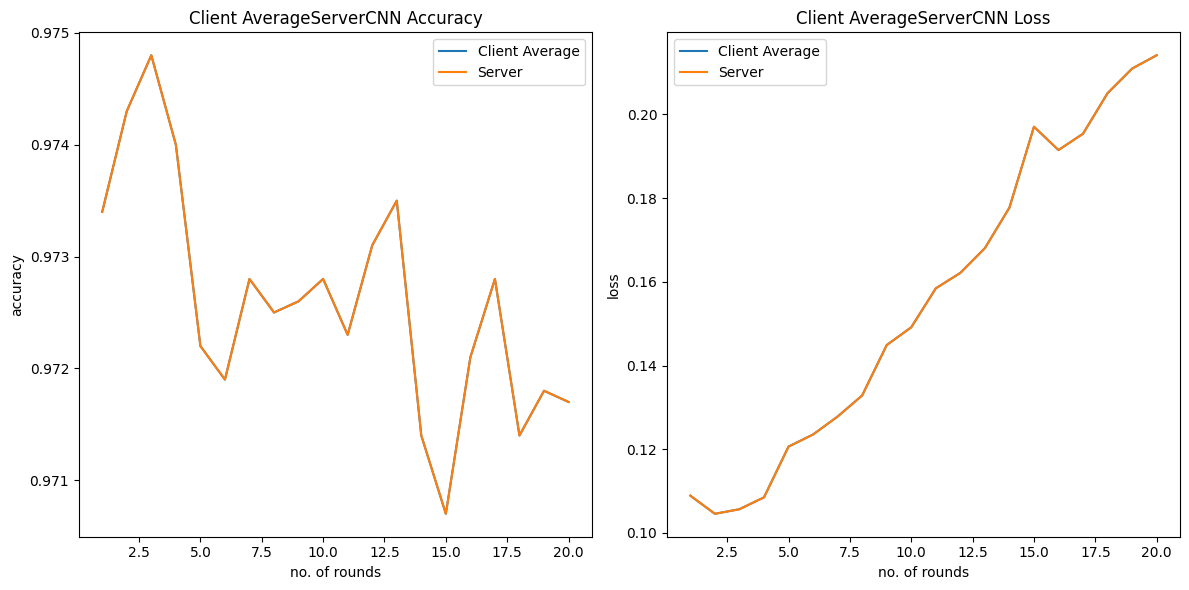

@@@@@@@@@@ avg client acc 0.9717000126838684
FEDPKDG START
CNN target sparsity 0
CNN target sparsity 0
CNN target sparsity 0
CNN target sparsity 0
CNN target sparsity 0
********* ROUND0-initial local generator
ROUND 0 local models [0.972100019454956, 0.972100019454956, 0.972100019454956, 0.972100019454956, 0.972100019454956] 0.35959121584892273
val_acc: [0.971666693687439, 0.971666693687439, 0.9733333587646484, 0.9649999737739563, 0.9666666388511658]
********* ROUND 1 *********
CNN target sparsity 0.025
CNN target sparsity 0.025
CNN target sparsity 0.025
CNN target sparsity 0.025
CNN target sparsity 0.025


Augmented dataset shape: (3000, 28, 28, 1), (3000,)
Added (6000,) data points to the public dataset
ROUND 1 local models [0.9128999710083008, 0.9128999710083008, 0.9128999710083008, 0.9128999710083008, 0.9128999710083008] 0.37041541934013367
val_acc: [0.9016666412353516, 0.9333333373069763, 0.8966666460037231, 0.8999999761581421, 0.9116666913032532]
Added (100,) data points to the public dataset
4/4 ━━━━━━━━━━━━━━━━━━━━ 11s 2s/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 9s 2s/step
KID score: 0.060801660156250215
global gen KID: 0.060801660156250215
global CNN acc: 0.8871698379516602 0.44294843077659607
********* ROUND 2 *********
CNN target sparsity 0.05
CNN target sparsity 0.05
CNN target sparsity 0.05
CNN target sparsity 0.05
CNN target sparsity 0.05
Augmented dataset shape: (320, 28, 28, 1), (320,)
Added (640,) data points to the public dataset
ROUND 2 local models [0.8901000022888184, 0.8901000022888184, 0.8901000022888184, 0.8901000022888184, 0.8901000022888184] 0.34211865067481995
val_acc: [0.

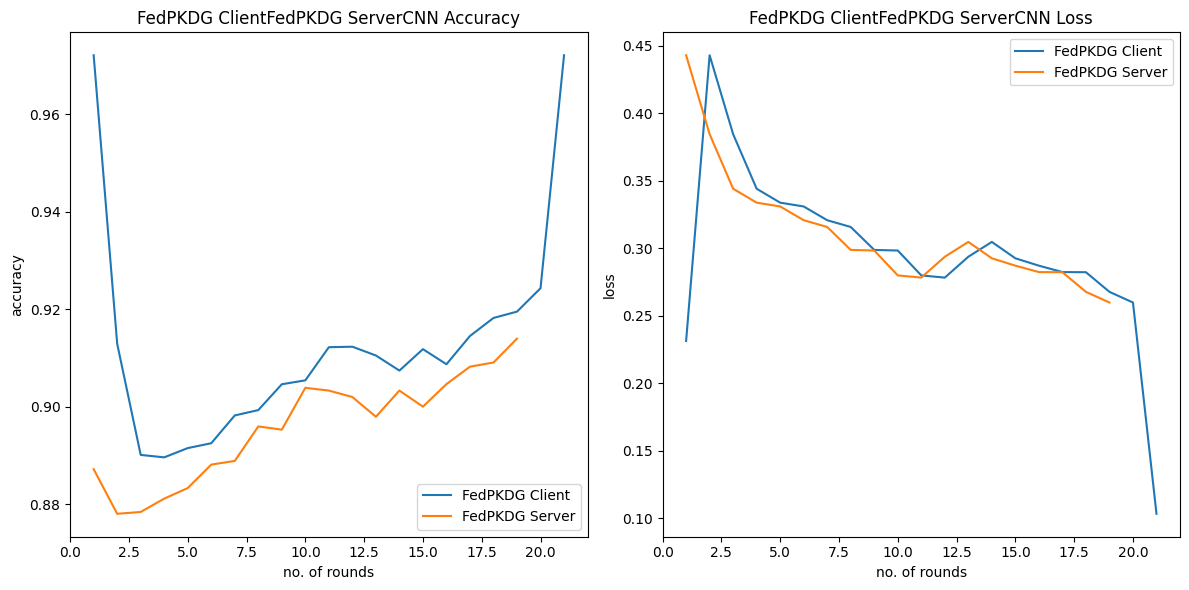

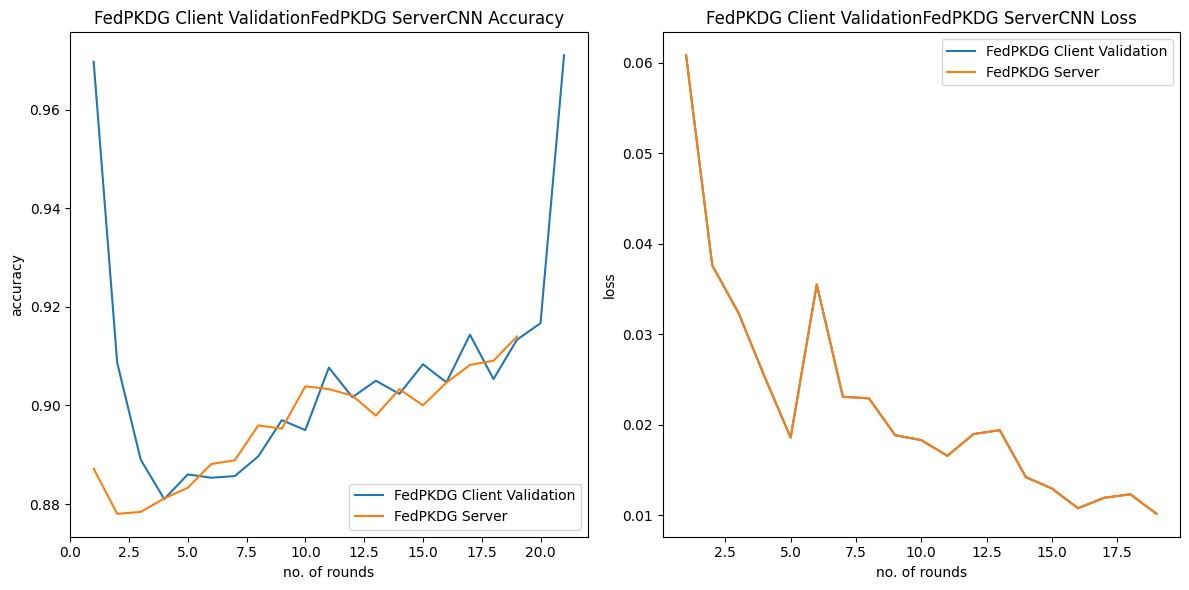

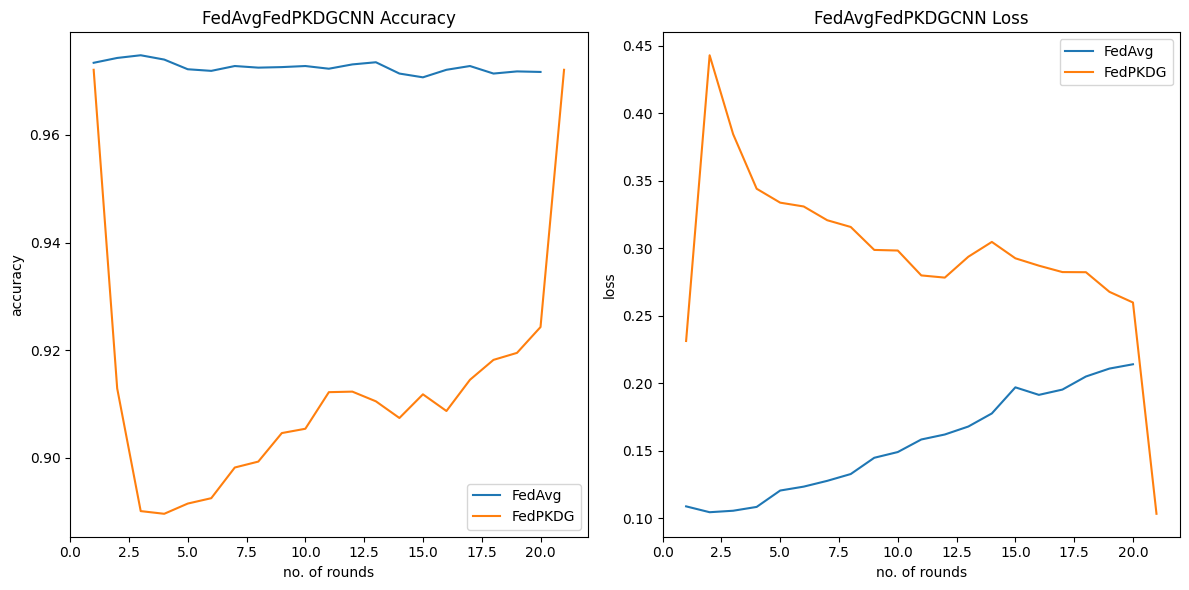

In [ ]:
run_test(smallCNN(),client_data)

## Different global models - 5 dirichlet clients r=0.5

r=0.5, comm_freq=5, total 15 rounds, pkdg on round 0: cnn_epochs = 15, gen_epochs=15

Label Distribution in Training Set  0.5 :
Label 0: 2967 instances
Label 1: 3413 instances
Label 2: 3038 instances
Label 3: 3054 instances
Label 4: 2912 instances
Label 5: 2654 instances
Label 6: 2896 instances
Label 7: 3107 instances
Label 8: 2995 instances
Label 9: 2964 instances
Client 1: 6000 samples
Client 2: 4353 samples
Client 3: 2880 samples
Client 4: 2668 samples
Client 5: 1852 samples
[[  88  185  567  321  702  992  164    4  230 2747]
 [  82  139   31  174  445  267 2326   87  585  217]
 [1591  321  388  230   29  189   47    4   81    0]
 [1206   31   73  226    3  140   40  676  273    0]
 [   0    3  640  190  142  107  319  126  325    0]]


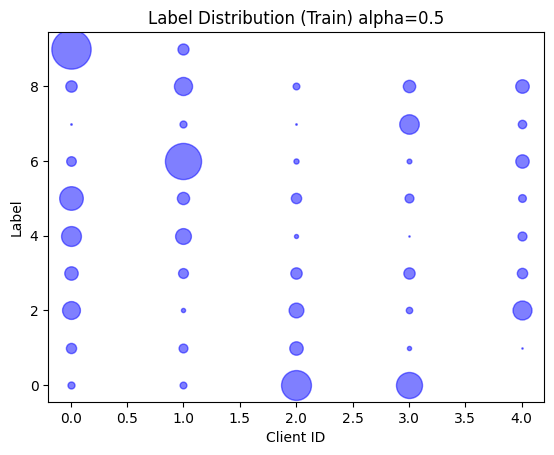

In [ ]:
#take sampled data
no_client=5
x_sample, y_sample=sample_training_data(0.5)
print_dist(y_sample,'0.5')
# generate client split
dir_alpha=0.5 # to change for different runs
client_data = dirichlet_split(x_sample, y_sample, alpha=dir_alpha, num_clients=5)
for i, (x, y) in enumerate(client_data):
    print(f"Client {i+1}: {len(x)} samples")
# Plot the bubble chart with normalized sizes
plot_bubble_chart(client_data_dist(client_data),dist_param=dir_alpha)

In [ ]:
#script
def rundiffarch():
  models=[smallCNN(), mediumCNN(), bigCNN()]
  accs=[]
  losses=[]
  for model in models:
    client_list = []
    for i in range(no_client):
      #partition dataset to mimic private data
      client_list.append(Client(model, client_data[i][0], client_data[i][1]))
    this_acc, this_loss=runpkdg(model,client_list,final_target_sparsity=0.4)
    accs.append(this_acc)
    losses.append(this_loss)
  return accs,losses


CNN target sparsity 0
CNN target sparsity 0
CNN target sparsity 0
CNN target sparsity 0
CNN target sparsity 0
********* ROUND0-initial local generator
ROUND 0 local models [0.8169999718666077, 0.8169999718666077, 0.8169999718666077, 0.8169999718666077, 0.8169999718666077] 0.33462822437286377
val_acc: [0.0, 0.45517241954803467, 0.9513888955116272, 0.9398496150970459, 0.9351351261138916]
********* ROUND 1 *********
CNN target sparsity 0.04000000000000001
CNN target sparsity 0.04000000000000001
CNN target sparsity 0.04000000000000001
CNN target sparsity 0.04000000000000001
CNN target sparsity 0.04000000000000001
Augmented dataset shape: (926, 28, 28, 1), (926,)
Added (1846,) data points to the public dataset
ROUND 1 local models [0.8589000105857849, 0.8589000105857849, 0.8589000105857849, 0.8589000105857849, 0.8589000105857849] 0.7032227516174316
val_acc: [0.12166666984558105, 0.45747125148773193, 0.8993055820465088, 0.8082706928253174, 0.7891891598701477]
Added (100,) data points to the 

4/4 ━━━━━━━━━━━━━━━━━━━━ 10s 2s/step
KID score: 0.10392050781250006
global gen KID: 0.10392050781250006
global CNN acc: 0.8469317555427551 0.4278431534767151
********* ROUND 2 *********
CNN target sparsity 0.08000000000000002
CNN target sparsity 0.08000000000000002
CNN target sparsity 0.08000000000000002
CNN target sparsity 0.08000000000000002
CNN target sparsity 0.08000000000000002
Augmented dataset shape: (320, 28, 28, 1), (320,)
Added (640,) data points to the public dataset
ROUND 2 local models [0.8672000169754028, 0.8672000169754028, 0.8672000169754028, 0.8672000169754028, 0.8672000169754028] 0.7324979305267334
val_acc: [0.17666666209697723, 0.4597701132297516, 0.8888888955116272, 0.7857142686843872, 0.7783783674240112]
Added (100,) data points to the public dataset
4/4 ━━━━━━━━━━━━━━━━━━━━ 10s 2s/step
3/4 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step

4/4 ━━━━━━━━━━━━━━━━━━━━ 10s 2s/step
KID score: 0.06258759765625
global gen KID: 0.06258759765625
global CNN acc: 0.855107843875885 0.36705490946769714
********* ROUND 3 *********
CNN target sparsity 0.12
CNN target sparsity 0.12
CNN target sparsity 0.12
CNN target sparsity 0.12
CNN target sparsity 0.12
Augmented dataset shape: (320, 28, 28, 1), (320,)
Added (640,) data points to the public dataset
ROUND 3 local models [0.8726999759674072, 0.8726999759674072, 0.8726999759674072, 0.8726999759674072, 0.8726999759674072] 0.6825500726699829
val_acc: [0.2266666740179062, 0.49425286054611206, 0.8854166865348816, 0.8308270573616028, 0.7621621489524841]
Added (100,) data points to the public dataset
4/4 ━━━━━━━━━━━━━━━━━━━━ 9s 2s/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 9s 2s/step
KID score: 0.05830595703125052
global gen KID: 0.05830595703125052
global CNN acc: 0.8585280776023865 0.36289799213409424
********* ROUND 4 *********
CNN target sparsity 0.16000000000000003
CNN target sparsity 0.160000000000000

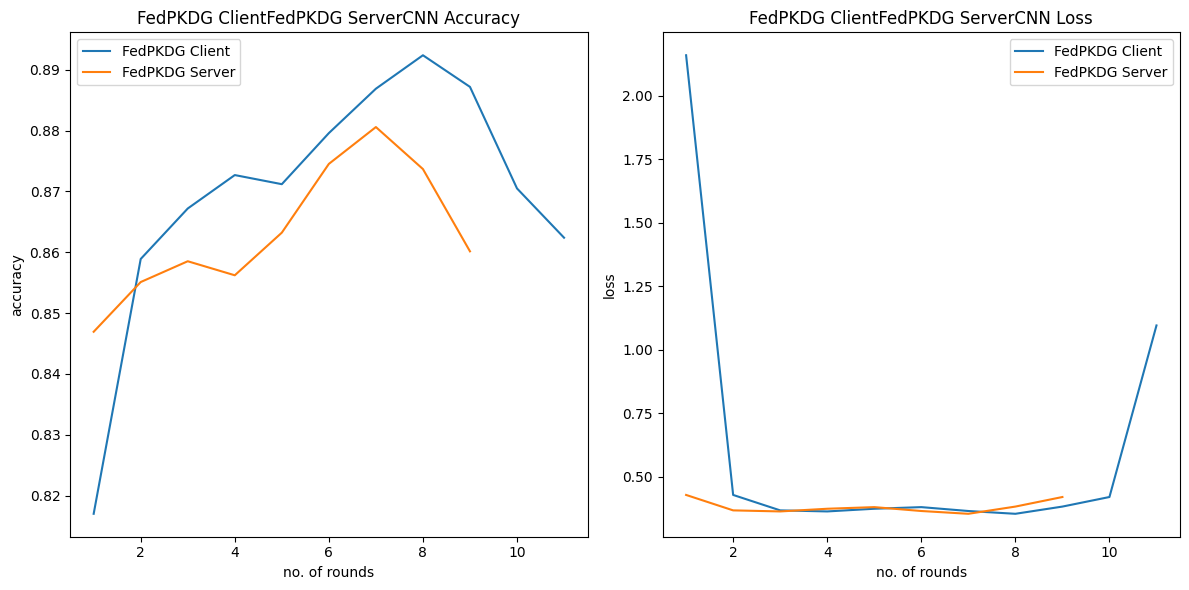

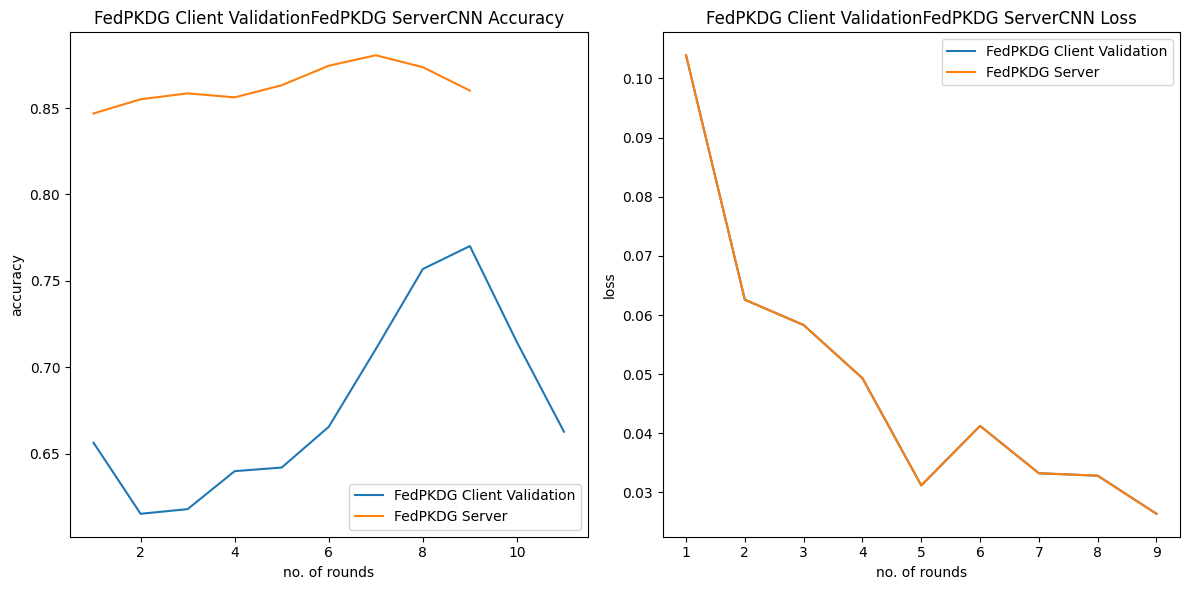

CNN target sparsity 0
CNN target sparsity 0
CNN target sparsity 0
CNN target sparsity 0
CNN target sparsity 0
********* ROUND0-initial local generator
ROUND 0 local models [0.817300021648407, 0.817300021648407, 0.817300021648407, 0.817300021648407, 0.817300021648407] 0.3766319751739502
val_acc: [0.0, 0.44597700238227844, 0.9548611044883728, 0.9248120188713074, 0.929729700088501]
********* ROUND 1 *********
CNN target sparsity 0.04000000000000001
CNN target sparsity 0.04000000000000001
CNN target sparsity 0.04000000000000001
CNN target sparsity 0.04000000000000001
CNN target sparsity 0.04000000000000001
Augmented dataset shape: (926, 28, 28, 1), (926,)
Added (1846,) data points to the public dataset
ROUND 1 local models [0.8946999907493591, 0.8946999907493591, 0.8946999907493591, 0.8946999907493591, 0.8946999907493591] 0.7002243399620056
val_acc: [0.43666666746139526, 0.5908045768737793, 0.9097222089767456, 0.7593985199928284, 0.7891891598701477]
Added (100,) data points to the public d

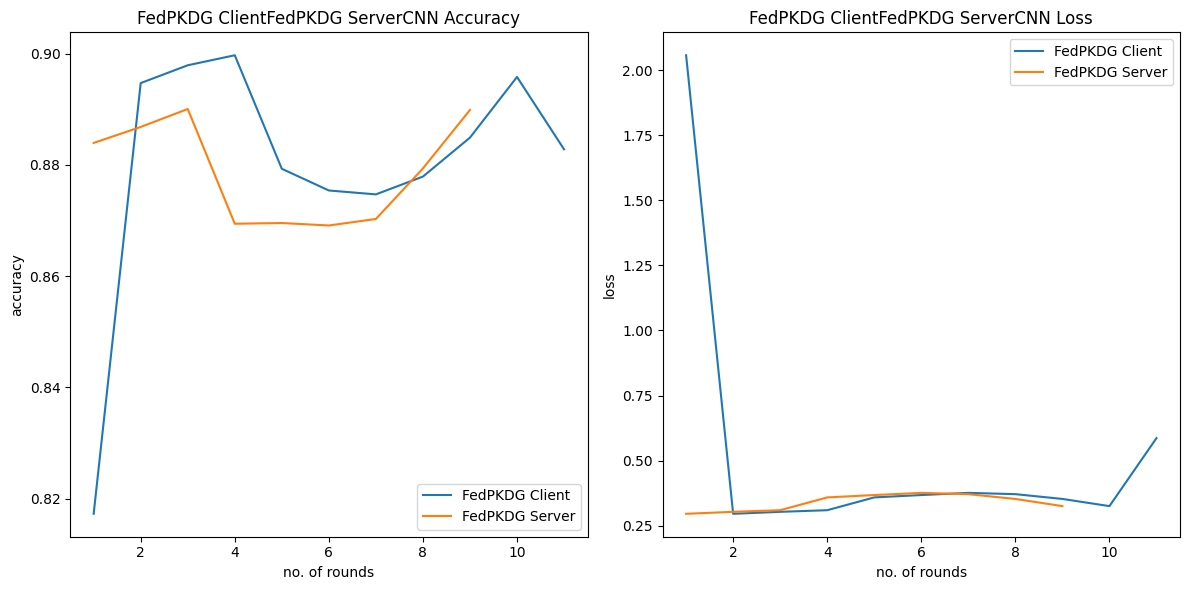

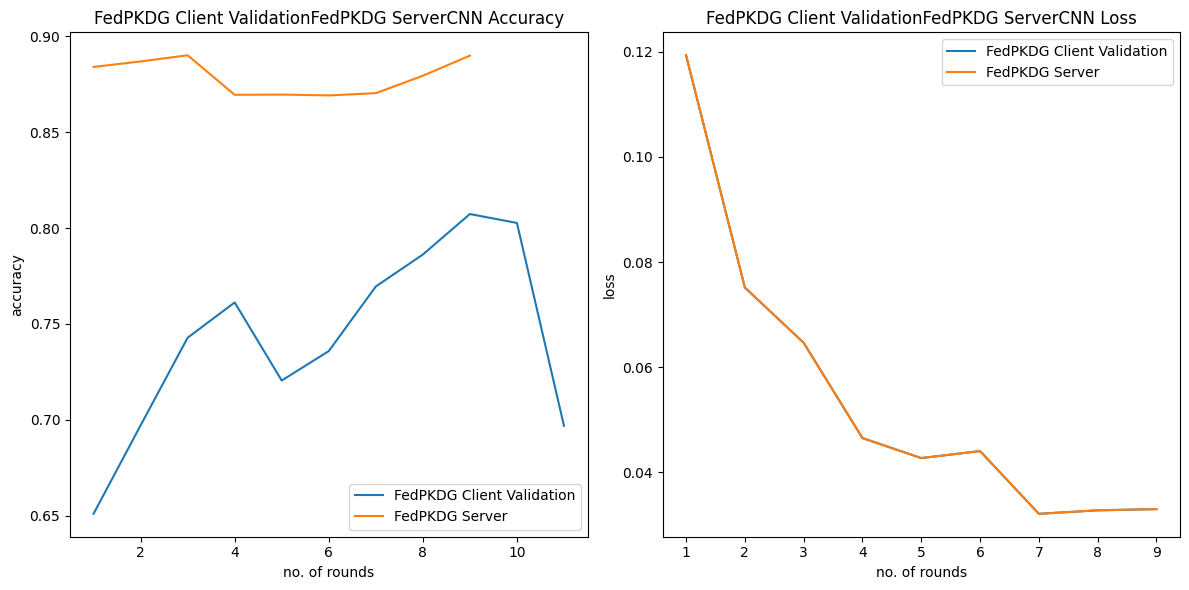

CNN target sparsity 0
CNN target sparsity 0
CNN target sparsity 0
CNN target sparsity 0
CNN target sparsity 0
********* ROUND0-initial local generator
ROUND 0 local models [0.8693000078201294, 0.8693000078201294, 0.8693000078201294, 0.8693000078201294, 0.8693000078201294] 0.31616833806037903
val_acc: [0.0, 0.4712643623352051, 0.9791666865348816, 0.9586465954780579, 0.9459459185600281]
********* ROUND 1 *********
CNN target sparsity 0.04000000000000001
CNN target sparsity 0.04000000000000001
CNN target sparsity 0.04000000000000001
CNN target sparsity 0.04000000000000001
CNN target sparsity 0.04000000000000001
Augmented dataset shape: (926, 28, 28, 1), (926,)
Added (1846,) data points to the public dataset
ROUND 1 local models [0.8687999844551086, 0.8687999844551086, 0.8687999844551086, 0.8687999844551086, 0.8687999844551086] 0.661503255367279
val_acc: [0.3633333444595337, 0.6137930750846863, 0.9027777910232544, 0.7744361162185669, 0.7891891598701477]
Added (100,) data points to the publ

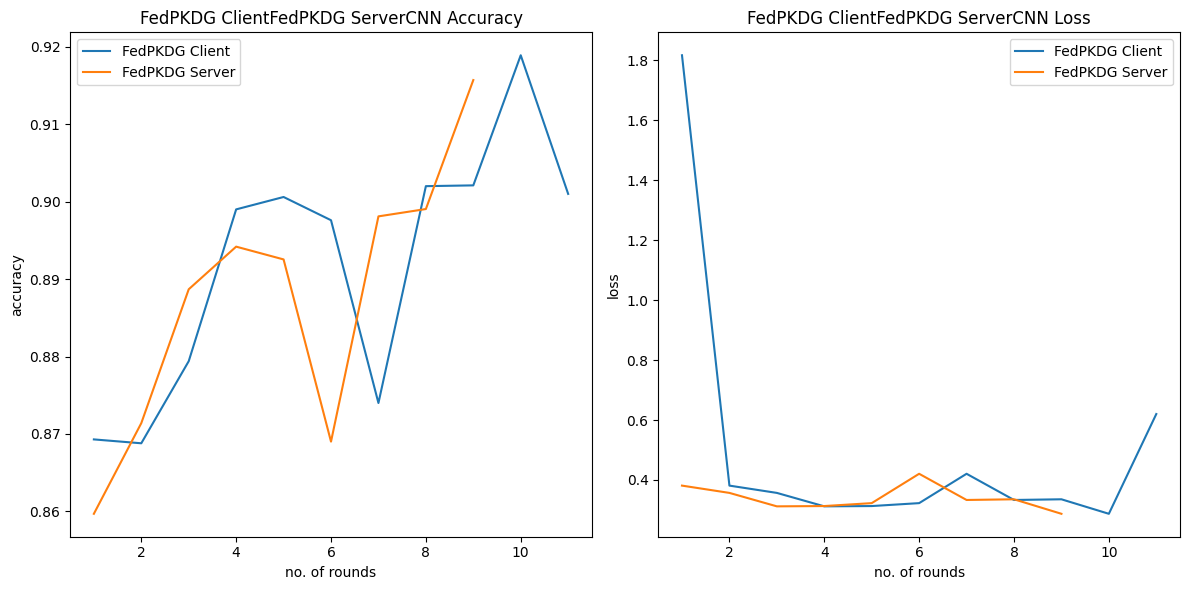

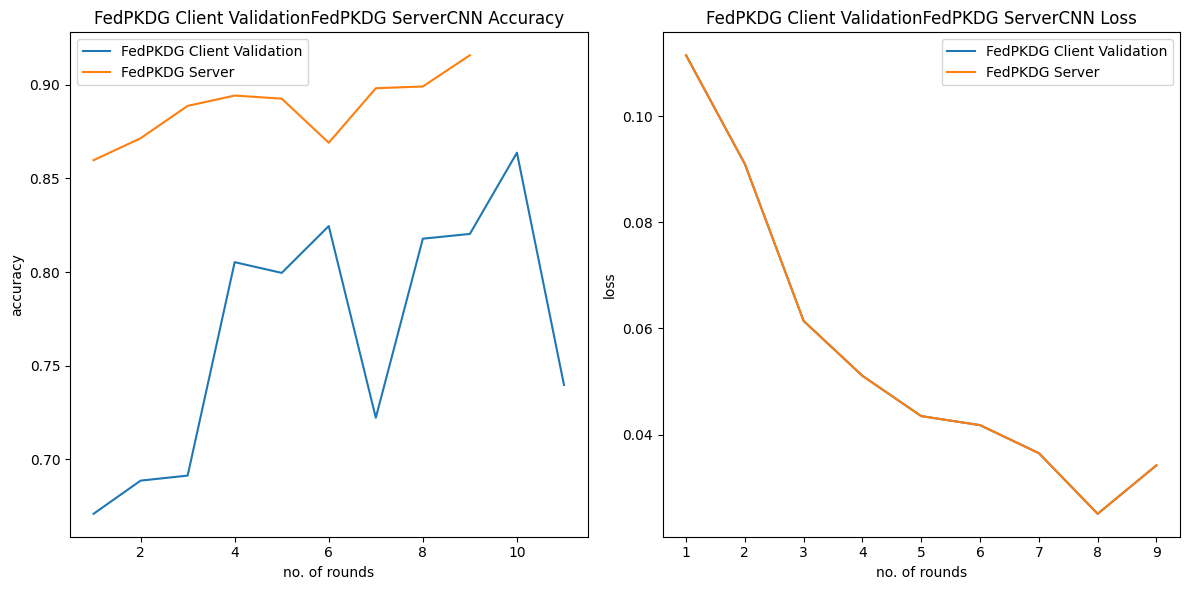

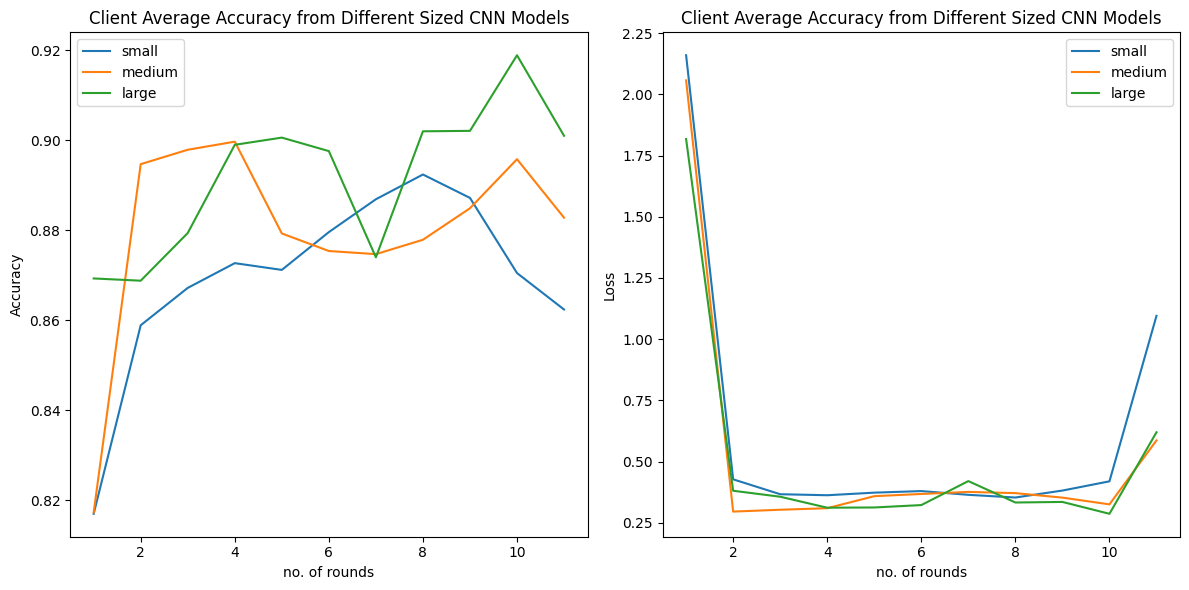

In [ ]:
accs,losses=rundiffarch()
# Create subplots
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 6))

smallacc=np.array(accs[0])
mediumacc=np.array(accs[1])
bigacc=np.array(accs[2])

acc_idx=list(range(1,len(smallacc)+1))

# Plot first two arrays on the left
ax1.plot(acc_idx, smallacc, label='small')
ax1.plot(acc_idx, mediumacc, label='medium')
ax1.plot(acc_idx, bigacc, label='large')
ax1.set_xlabel('no. of rounds')
ax1.set_ylabel('Accuracy')
ax1.set_title('Client Average Accuracy from Different Sized CNN Models')
ax1.legend()


# Plot second two arrays on the right
smallloss=np.array(losses[0])
mediumloss=np.array(losses[1])
bigloss=np.array(losses[2])

loss_idx=list(range(1,len(smallloss)+1))

ax2.plot(loss_idx, smallloss, label='small')
ax2.plot(loss_idx, mediumloss, label='medium')
ax2.plot(loss_idx, bigloss, label='large')
ax2.set_xlabel('no. of rounds')
ax2.set_ylabel('Loss')
ax2.set_title('Client Average Accuracy from Different Sized CNN Models')
ax2.legend()

# Display the plot
plt.tight_layout()
plt.show()

In [ ]:
# Create subplots
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 6))

smallacc=np.array(accs[0])
mediumacc=np.array(accs[1])
bigacc=np.array(accs[2])

acc_idx=list(range(1,len(smallacc)+1))

# Plot first two arrays on the left
ax1.plot(acc_idx, smallacc, label='small')
ax1.plot(acc_idx, mediumacc, label='medium')
ax1.plot(acc_idx, bigacc, label='large')
ax1.set_xlabel('no. of rounds')
ax1.set_ylabel('Accuracy')
ax1.set_title('Client Average Accuracy from Different Sized CNN Models')
ax1.legend()


# Plot second two arrays on the right
smallloss=np.array(losses[0])
mediumloss=np.array(losses[1])
bigloss=np.array(losses[2])

loss_idx=list(range(1,len(smallloss)+1))

ax2.plot(loss_idx, smallloss, label='small')
ax2.plot(loss_idx, mediumloss, label='medium')
ax2.plot(loss_idx, bigloss, label='large')
ax2.set_xlabel('no. of rounds')
ax2.set_ylabel('Loss')
ax2.set_title('Client Average Accuracy from Different Sized CNN Models')
ax2.legend()

# Display the plot
plt.tight_layout()
plt.show()